In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: LOONEN, MARIT (0961708)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

As I was unsure of effects, I experimented with number of nodes in the layers(e.g.100-50-25) and batchsize(50 to 10). Adagrad as optimizer gave a smoother learning curve, but was slow, so I changed number of epochs to 50 and a somewhat higher learning rate (0.005) to speed up the learning (accuracy=.71). I tried adding an extra layer and more nodes per layer(400-200-100-50), which resulted in .82 accuracy. My model slightly overfits (loss is smaller than val_loss)  (length: 470)



Max val score: 82.14%


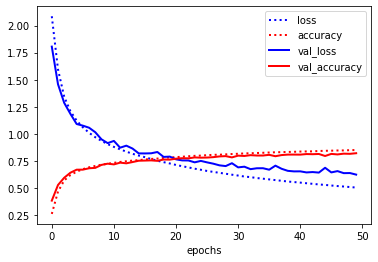

Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_128 (Reshape)        (None, 3072)              0         
_________________________________________________________________
dense_523 (Dense)            (None, 400)               1229200   
_________________________________________________________________
dense_524 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_525 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_526 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_527 (Dense)            (None, 10)                510       
Total params: 1,335,060
Trainable params: 1,335,060
Non-trainable params: 0
__________________________________________

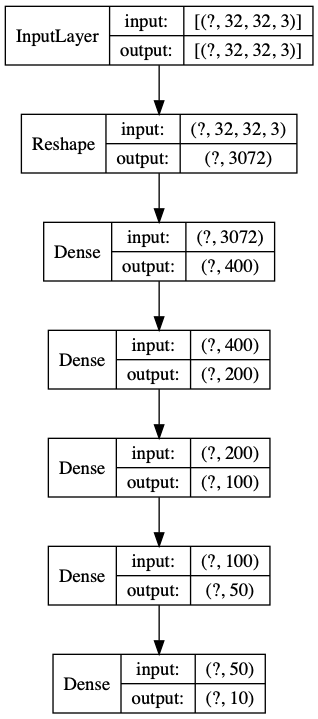

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

I used rgb2gray to convert X_train and X_val, and put these and y_train y_val in the preprocessed_split. Using this to run the model built in 1.1 (except for reshaping the input layer to fit the 32x32x1 greyscale data), it yields similar results and learning curve as 1.1: it still slightly overfits and has a comparable accuracy of .81. I expected the model to perform better with the greyscaled data as it removes complexity that is not needed to recognize numbers.  (length: 469)



Max val score: 81.22%


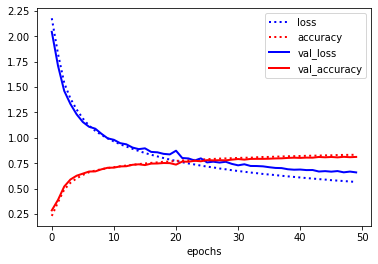

Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_149 (Reshape)        (None, 1024)              0         
_________________________________________________________________
dense_616 (Dense)            (None, 400)               410000    
_________________________________________________________________
dense_617 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_618 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_619 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_620 (Dense)            (None, 10)                510       
Total params: 515,860
Trainable params: 515,860
Non-trainable params: 0
______________________________________________

In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

L1 regularization did not converge well, L2 was much better but still slightly overfitted and resulted in lower accuracy than before. So I tried adding dropout layers (.5/.3), but these underfitted, so I lowered this to .1. This worked well; neither over- nor underfit, with the same accuracy as the before. I tried increasingly bigger values for the dropouts(.1, .2, .3), but this caused too much information to be lost, so I stayed at .1 for all dropout layers.  (length: 465)



Max val score: 82.02%


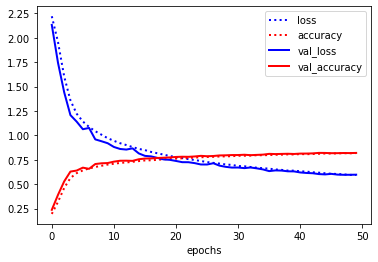

def build_model_1_3():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
  model.add(layers.Dense(400, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer= optimizers.Adagrad(learning_rate=0.005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

I started with 3 conv-layers (32-64-128 filters) and later increased this to 6 (2x32-2x64-2x128) to allow for higher model complexity. Throughout, I experimented somewhat, but fewer filters decreased accuraccy (not enough complexity), and more filters did not increase accuracy or did not converge. To reduce overfitting and provide basic translation invariance, I added maxpooling layers between conv layers, and later (as it still overfitted) also added dropout layers. After some experimentation with dropout fraction, increasing from .2 to .5 gave the best results (no over- nor underfit). I used adam as optimizer as the learning curve was smoother than rmsprop, and faster (and more accurate) than adagrad. Bigger filter size or bigger dense layer did not work.  (length: 769)



Max val score: 94.45%


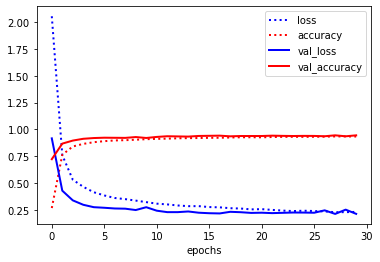

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)        

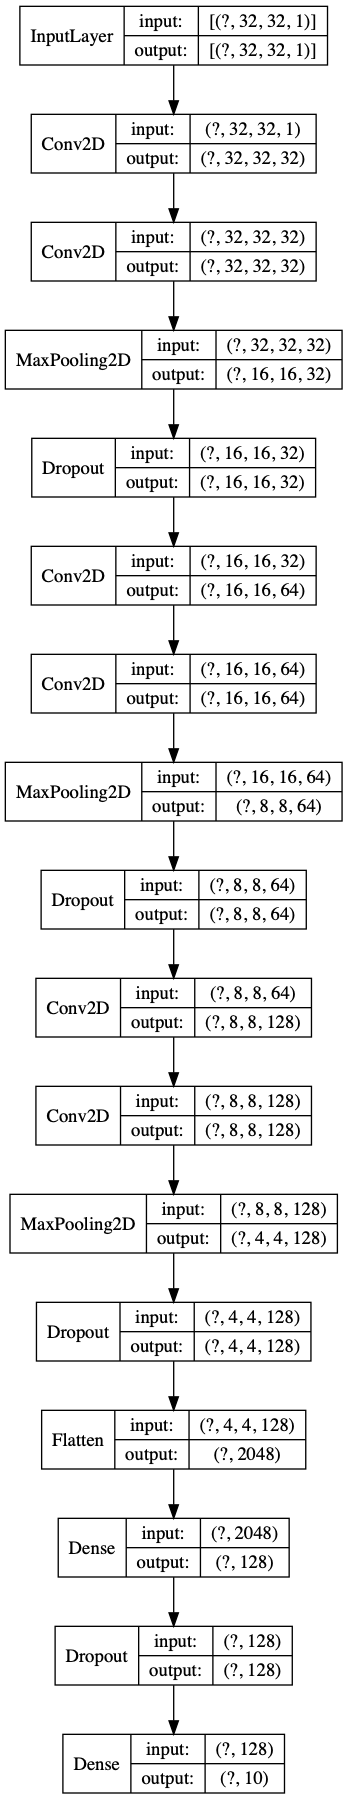

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

I used ImageDataGenerator to create variations of X_train. I found that for all values above .2 (or for shear_range; .1) the model did not coverge(but .2 yielded better accuracy than .1). Also, for horizontal and/or vertical flips, the model could not converge (logical as numbers in the data are not mirrored/turned, 5&2, 6&9 are confusing). With the best values,no flips, this model performs similar to 2.1, but when I lower dropout(comments) lower val_los is found.  (length: 470)



Max val score: 93.65%


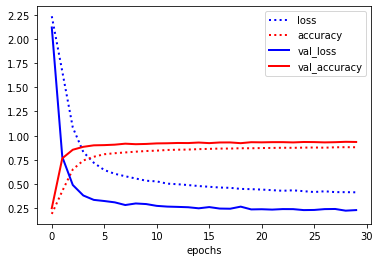


train_datagen = ImageDataGenerator(
    rotation_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

Accuracy on testdata is .935, which is close to val_accuracy in model 2.2: it does not overfit. To see where mistakes are, I plot the confusionmatrix. You can clearly see the diagonal line (yay), and most errors seem to be made a small amount of the time (e.g. max 30 times). But there are some exceptions: 7s are relatively often classified as 1 or 2, and 5s are quite often classified as 3. Because of the errors of the 7, I visualize the first 14 cases of actual 7s that were misclassified. Some errors are very understandable; when there is more than one number in the picture, when the picture is very vague, and some of the 7s do just really look like 1s...  (length: 665)

Test score: 0.93%


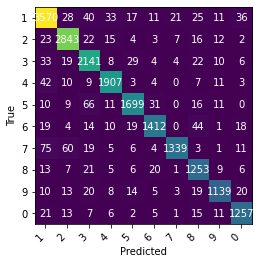

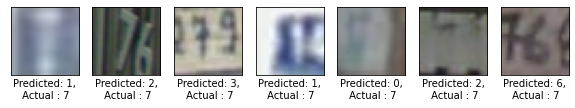

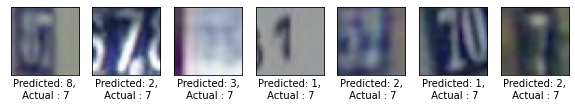

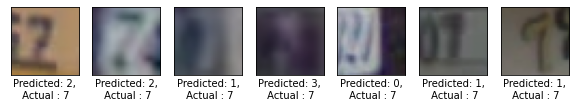

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

I have visualized the first(32x32) and middle(16x16) conv layers; after that the resolution is too low to interpret due to max-pooling. I can see that layer1 responds to some elements such as vertical edges (e.g. 10th filter, 1st row). Layer2 already seems to combine some of the basic elements (e.g. curves). The activations in layer 5 and 6 are much more abstract, but e.g. seem to be responding to content on different sides of edges, perimeters, etc.  (length: 456)



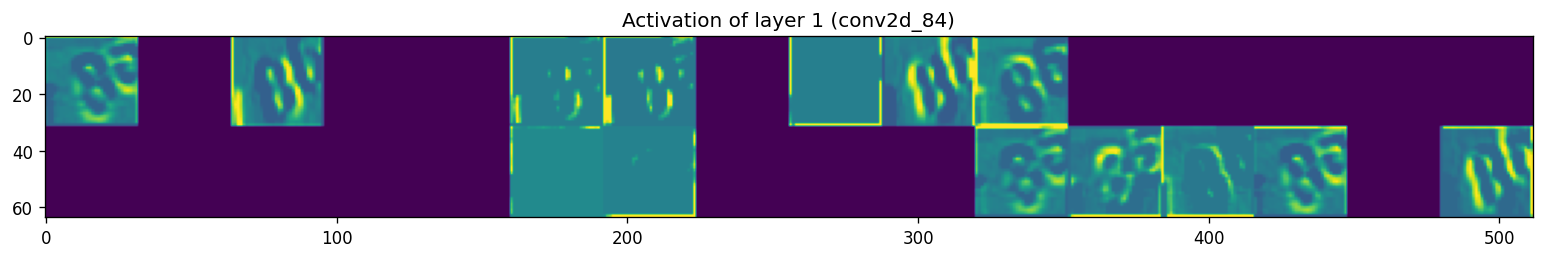

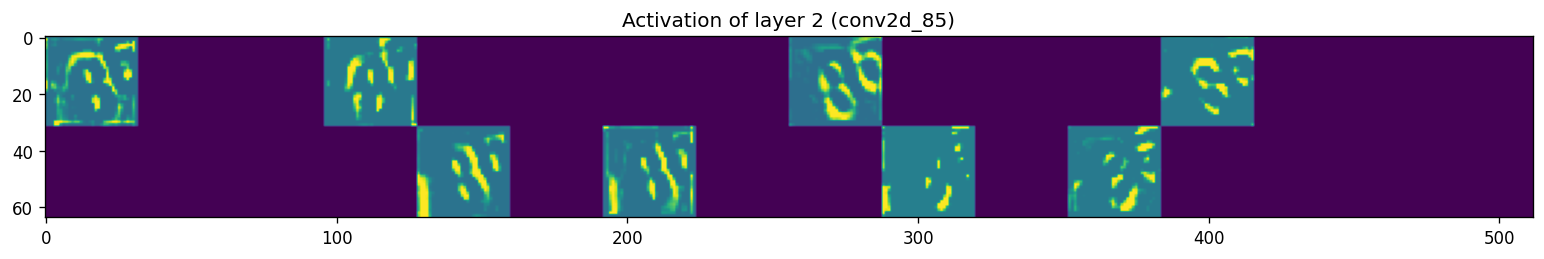

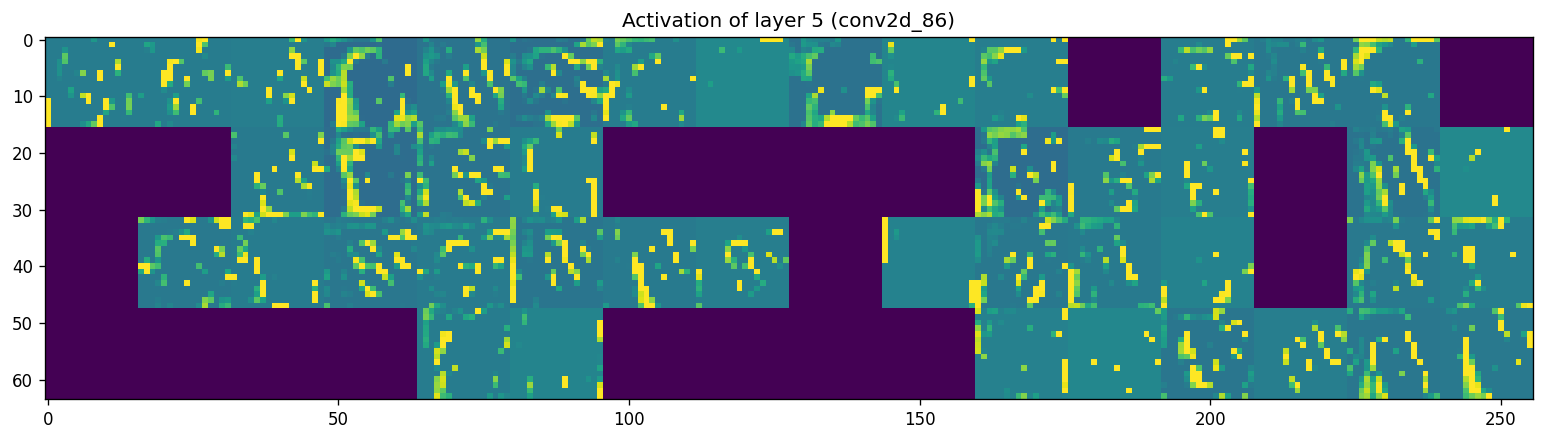

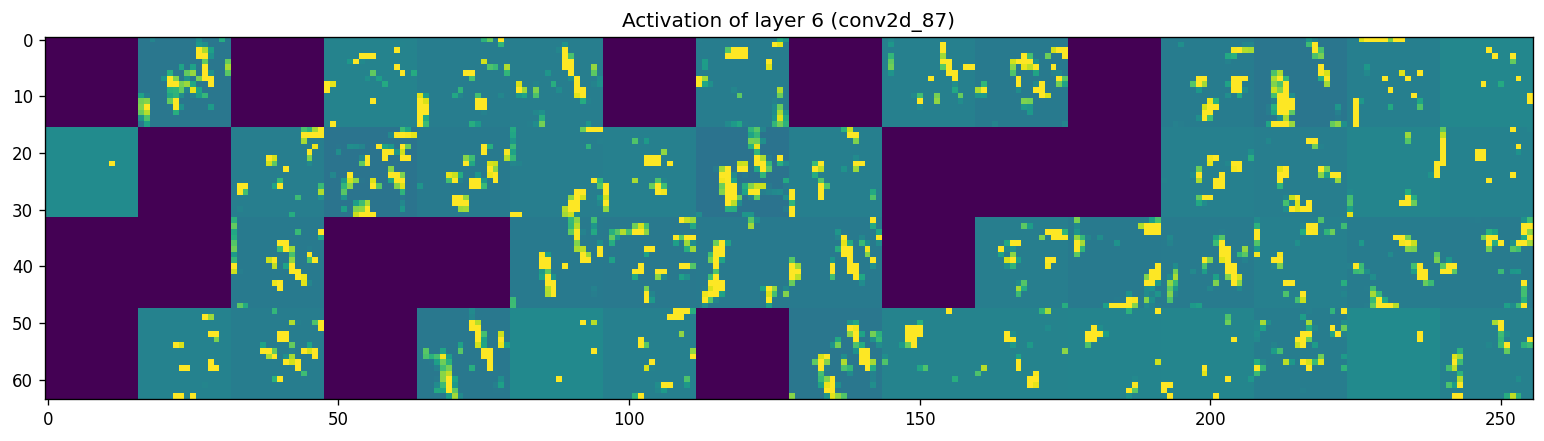

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

ERROR, could not build class activation plot. Please check original report
def plot_3_3():
  input_image = np.expand_dims(X_test_g[0], axis=0)

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_89')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(input_image)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  img = X_test_g[0]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  image = heatmap * 1.3 * img
  cv2_imshow(cv2.resize(image, (300, 300)))



#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

In model 4.1, I first froze the entire conv base and added a dense hidden layer (and dense, softmax). With some different settings (extra layer, more filters), this leaded to max .58 val_acc. When unfreezing the 1st layer of the 5th conv-block, val_acc rose to around .8. Fine tuning by unfreezing all 3 layers in the 5th block immediately raised val_acc to .93. This finally led to an accuracy similar to my previous models (although somewhat overfitting).  (length: 459)



Max val score: 94.08%


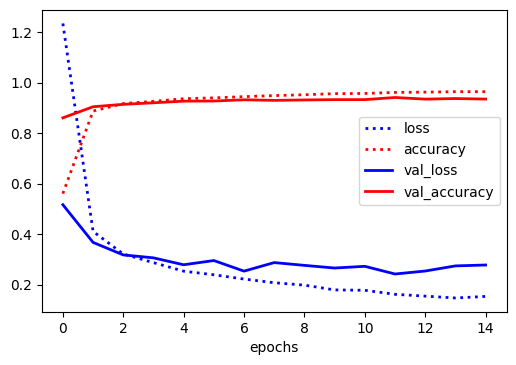

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_67 (Dense)             (None, 10)                10250     
Total params: 16,299,850
Trainable params: 16,299,850
Non-trainable params: 0
_________________________________________

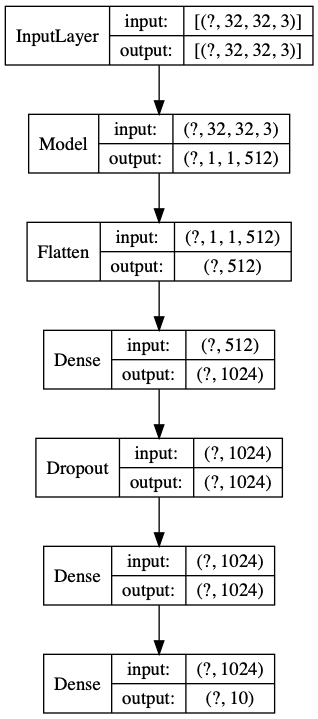

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

In store_embeddings, I used the conv_base of model_4_1 to predict X_test and X_train, and store_embedding to save these. In generate_pipeline, I added a simple pipeline. Evaluate_pipeline fits the pipe on embedded train data, and then evaluates on embedded test data. Evaluate_4_2 looks for the embedded data (base_dir), and otherwise uses store_embeddings, and then runs evaluate_pipeline. Using RF, I get .92 accuracy, surprisginly almost as high as the past models.  (length: 470)

Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())])
def store_embeddings(X_train, X_test):
  """ Stores all necessary embeddings to file
  """
  conv_base_4 = model_4.get_layer("vgg16")
  X_train = conv_base_4.predict(X_train)
  store_embedding(X_train, "X_train_e")

  X_test = conv_base_4.predict(X_test)
  store_embedding(X_test, "X_test_e")

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accur

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 12.90 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
